In [87]:
import numpy as np
from astropy.table import Table
import astropy.units as u
import pandas as pd
from astropy.io import fits
import os
from glob import glob
import matplotlib.pyplot as plt
from astropy.visualization import ZScaleInterval
from stdatamodels.jwst import datamodels as dm

from BNBG.Pipeline.BetterBackgroundSubtractStep import BetterBackgroundStep

CRDS folder at /home/tim-dewachter/Documents/Thèse/BetterNIRSpecBackground/CRDS
Logger loaded
CRDS folder at /home/tim-dewachter/Documents/Thèse/BetterNIRSpecBackground/CRDS


In [2]:
IDS = (
	8393,
	21848,
	8554,
	20302
)

In [82]:
def keepIDS(filelist, i=3):
	id_list = np.array([int(os.path.basename(f).split("_")[i][1:]) for f in filelist])
	result = {}
	for idx in IDS:
		if idx in id_list:
			index = np.where(id_list == idx)[0][0]
			result[idx] = fits.open(filelist[index])
	return result

def getMultiSlitIds(filelist):
	result = {}
	files = {}
	for idx in IDS:
		print(f"\nSource ID : {idx}")
		print("-------------------")
		result[idx] = []
		files[idx] = []
		for _,f in enumerate(filelist):
			print(f"File ({_}/{len(filelist)}) : {os.path.dirname(f)}/{os.path.basename(f)}")
			f = fits.open(f)
			for hdu in f:
				if hdu.name == "SCI" and hdu.header["SOURCEID"] == idx:
					print("Found an HDU")
					result[idx] += [hdu]
					files[idx] += [filelist[_]] if filelist[_] not in files[idx] else []

	return result, files


basic_s2d = keepIDS(glob("/home/tim-dewachter/Documents/Thèse/CAPERS/V0.1/CAPERS_UDS_V0.1/P*/*s2d.fits"))
basic_x1d = keepIDS(glob("/home/tim-dewachter/Documents/Thèse/CAPERS/V0.1/CAPERS_UDS_V0.1/P*/*x1d.fits"))
basic_table = {}
for key,f in basic_x1d.items():
	basic_table[key] = Table.read(f,1)

bnbg_s2d = keepIDS(glob("/home/tim-dewachter/Documents/Thèse/BetterNIRSpecBackground/mastDownload/JWST/CAPERS/P*/Final/*s2d.fits"),i=1)
bnbg_x1d = keepIDS(glob("/home/tim-dewachter/Documents/Thèse/BetterNIRSpecBackground/mastDownload/JWST/CAPERS/P*/Final/*x1d.fits"),i=1)
bnbg_table = {}
for key,f in bnbg_x1d.items():
	bnbg_table[key] = Table.read(f,1)

stage2_cal,cal_list = getMultiSlitIds(glob("/home/tim-dewachter/Documents/Thèse/BetterNIRSpecBackground/mastDownload/JWST/CAPERS/P*/*cal.fits"))
stage2_s2d,s2d_list = getMultiSlitIds(glob("/home/tim-dewachter/Documents/Thèse/BetterNIRSpecBackground/mastDownload/JWST/CAPERS/P*/*s2d.fits"))
stage2_bkg,bkg_list = getMultiSlitIds(glob("/home/tim-dewachter/Documents/Thèse/BetterNIRSpecBackground/mastDownload/JWST/CAPERS/P*/*bkg-BNBG.fits"))
stage2_sub,sub_list = getMultiSlitIds(glob("/home/tim-dewachter/Documents/Thèse/BetterNIRSpecBackground/mastDownload/JWST/CAPERS/P*/*cal-BNBG.fits"))



Source ID : 8393
-------------------
File (0/96) : /home/tim-dewachter/Documents/Thèse/BetterNIRSpecBackground/mastDownload/JWST/CAPERS/P1/jw06368022001_05101_00002_nrs2_cal.fits
File (1/96) : /home/tim-dewachter/Documents/Thèse/BetterNIRSpecBackground/mastDownload/JWST/CAPERS/P1/jw06368022001_05101_00001_nrs1_cal.fits
File (2/96) : /home/tim-dewachter/Documents/Thèse/BetterNIRSpecBackground/mastDownload/JWST/CAPERS/P1/jw06368023001_03101_00002_nrs1_cal.fits
File (3/96) : /home/tim-dewachter/Documents/Thèse/BetterNIRSpecBackground/mastDownload/JWST/CAPERS/P1/jw06368024001_03101_00002_nrs1_cal.fits
File (4/96) : /home/tim-dewachter/Documents/Thèse/BetterNIRSpecBackground/mastDownload/JWST/CAPERS/P1/jw06368023001_05101_00003_nrs2_cal.fits
File (5/96) : /home/tim-dewachter/Documents/Thèse/BetterNIRSpecBackground/mastDownload/JWST/CAPERS/P1/jw06368022001_03101_00002_nrs2_cal.fits
File (6/96) : /home/tim-dewachter/Documents/Thèse/BetterNIRSpecBackground/mastDownload/JWST/CAPERS/P1/jw063680

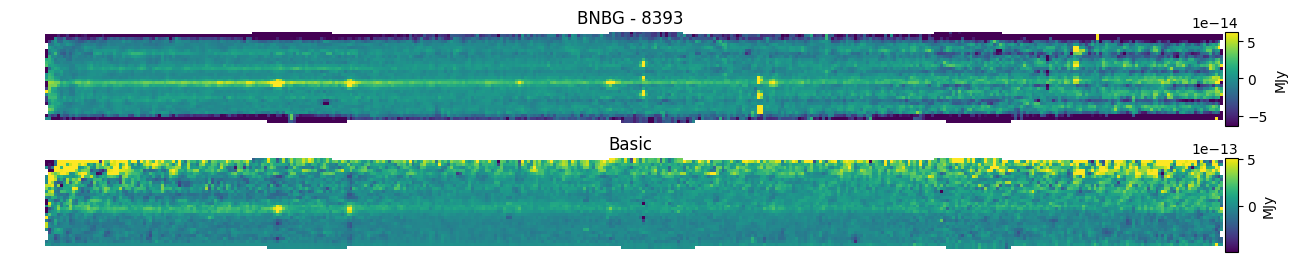

2025-03-18 19:23:05,196 - stpipe - INFO - [12525]  [BetterBackground] : Initializing Better Background NIRSpec


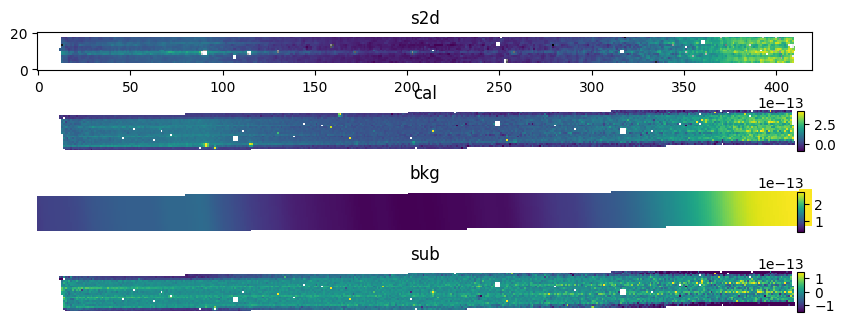

2025-03-18 19:23:05,890 - stpipe - INFO - [12525]  [BetterBackground] : Initializing Better Background NIRSpec


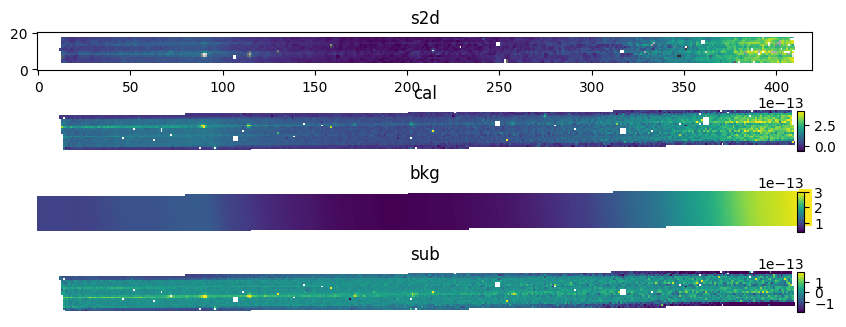

2025-03-18 19:23:06,209 - stpipe - INFO - [12525]  [BetterBackground] : Initializing Better Background NIRSpec


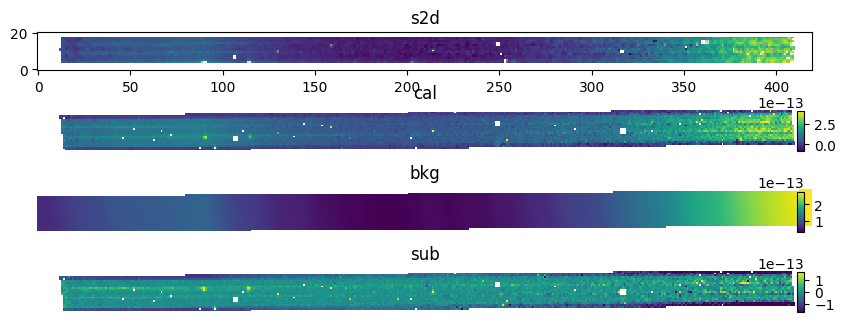

2025-03-18 19:23:06,534 - stpipe - INFO - [12525]  [BetterBackground] : Initializing Better Background NIRSpec


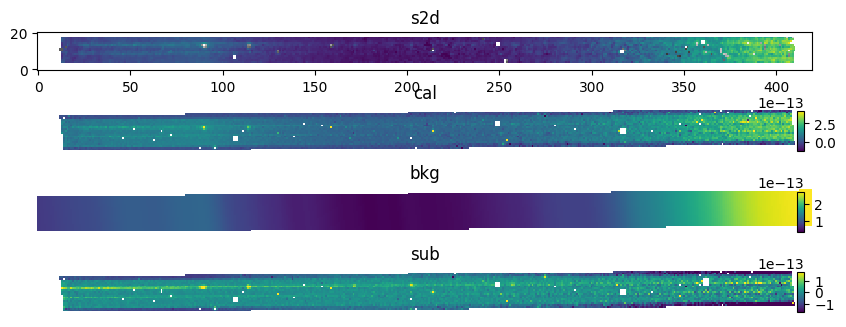

2025-03-18 19:23:06,863 - stpipe - INFO - [12525]  [BetterBackground] : Initializing Better Background NIRSpec


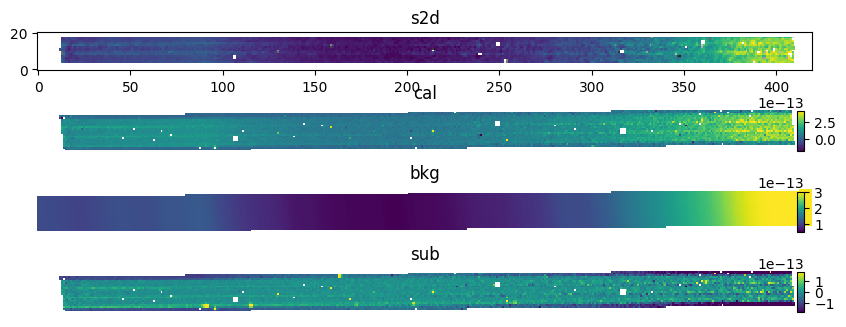

2025-03-18 19:23:07,191 - stpipe - INFO - [12525]  [BetterBackground] : Initializing Better Background NIRSpec


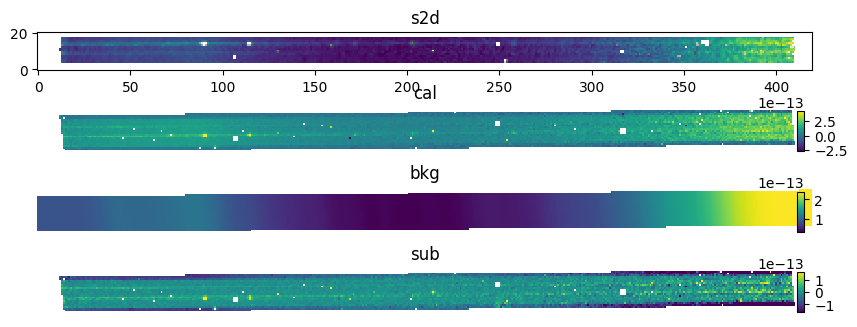

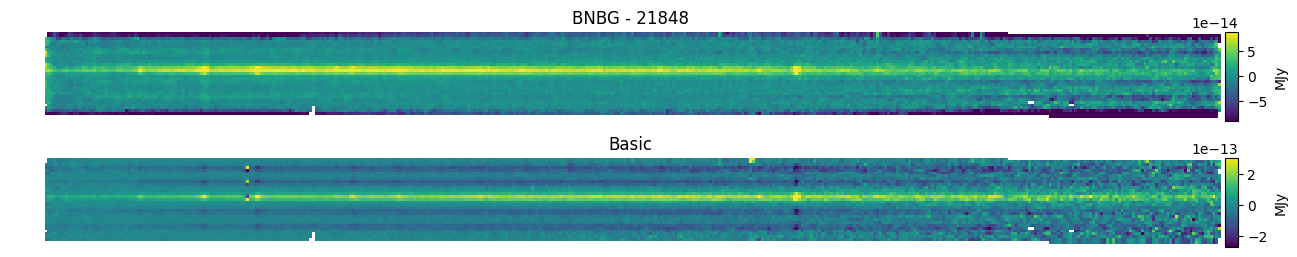

2025-03-18 19:23:07,629 - stpipe - INFO - [12525]  [BetterBackground] : Initializing Better Background NIRSpec


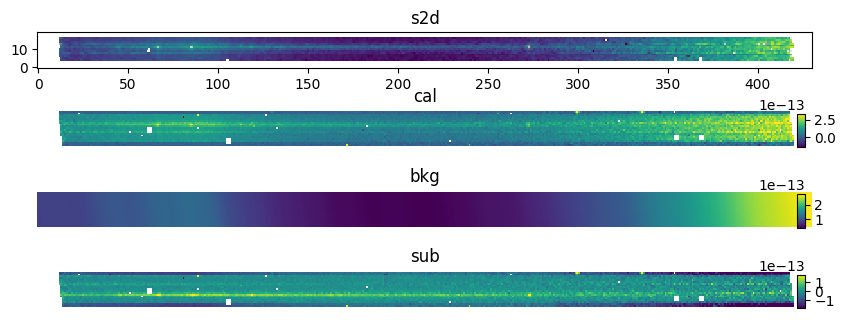

2025-03-18 19:23:07,958 - stpipe - INFO - [12525]  [BetterBackground] : Initializing Better Background NIRSpec


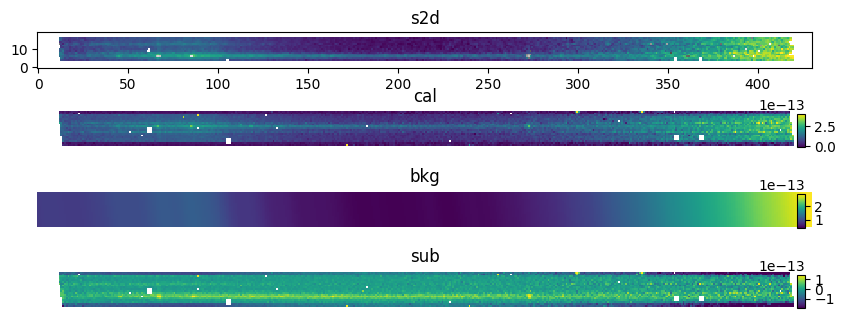

2025-03-18 19:23:08,281 - stpipe - INFO - [12525]  [BetterBackground] : Initializing Better Background NIRSpec


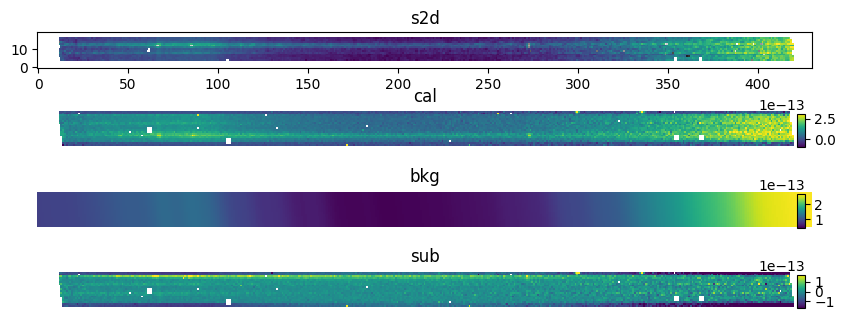

2025-03-18 19:23:08,604 - stpipe - INFO - [12525]  [BetterBackground] : Initializing Better Background NIRSpec


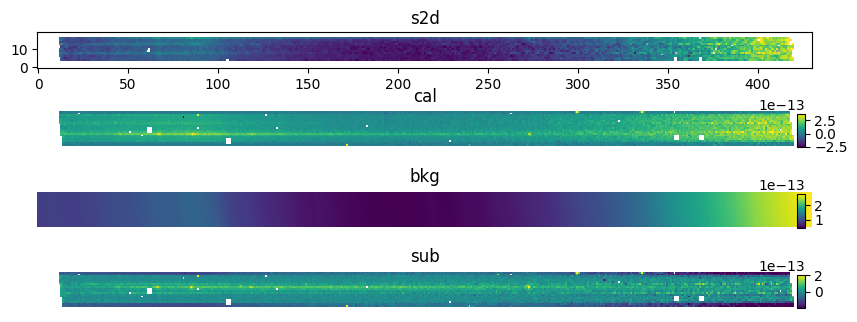

2025-03-18 19:23:08,922 - stpipe - INFO - [12525]  [BetterBackground] : Initializing Better Background NIRSpec


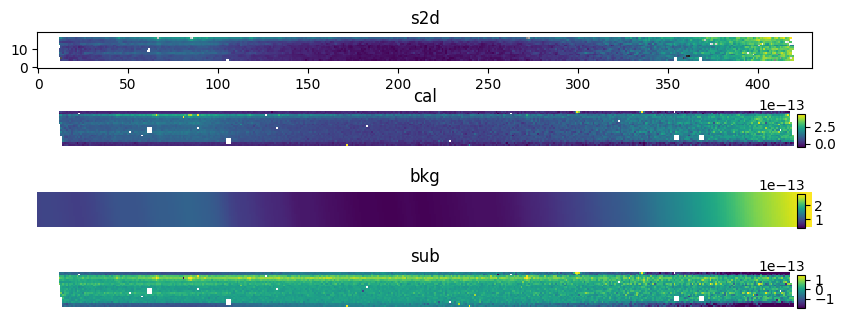

2025-03-18 19:23:09,511 - stpipe - INFO - [12525]  [BetterBackground] : Initializing Better Background NIRSpec


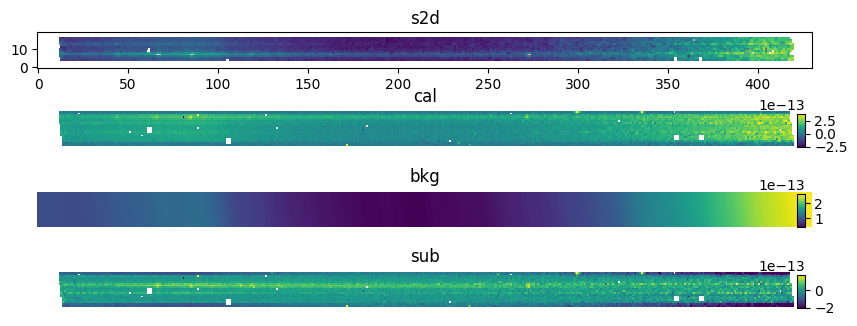

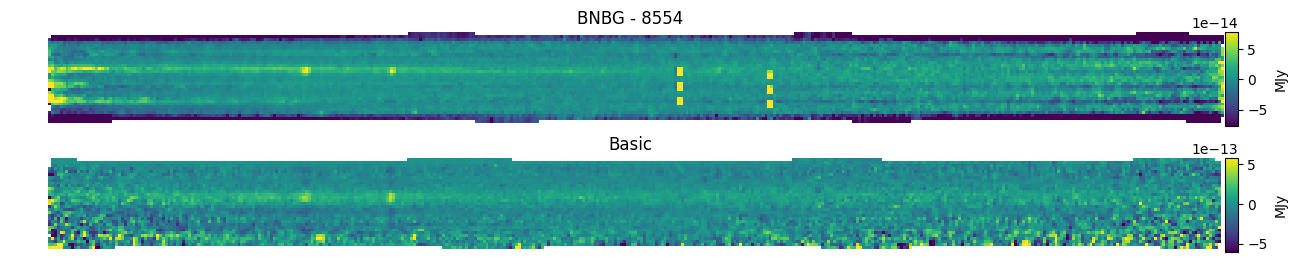

2025-03-18 19:23:09,992 - stpipe - INFO - [12525]  [BetterBackground] : Initializing Better Background NIRSpec


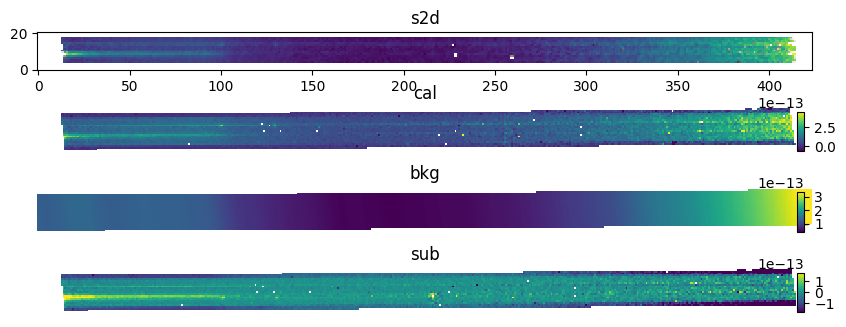

2025-03-18 19:23:10,325 - stpipe - INFO - [12525]  [BetterBackground] : Initializing Better Background NIRSpec


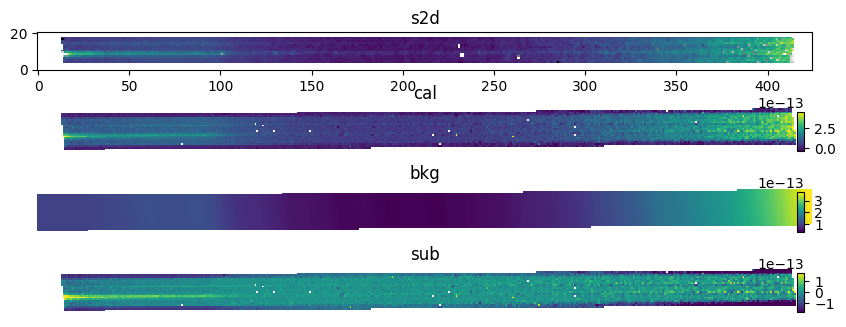

2025-03-18 19:23:10,659 - stpipe - INFO - [12525]  [BetterBackground] : Initializing Better Background NIRSpec


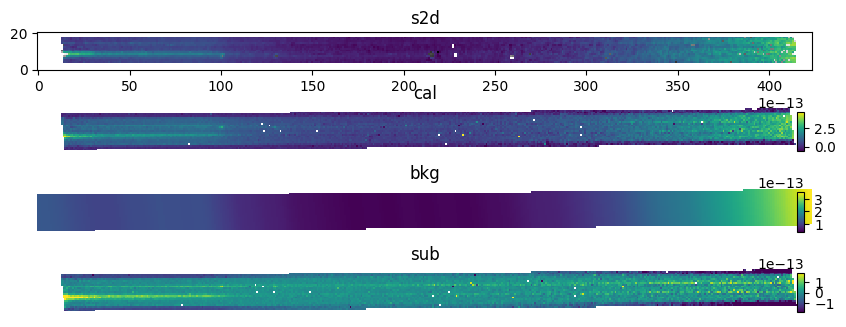

2025-03-18 19:23:11,002 - stpipe - INFO - [12525]  [BetterBackground] : Initializing Better Background NIRSpec


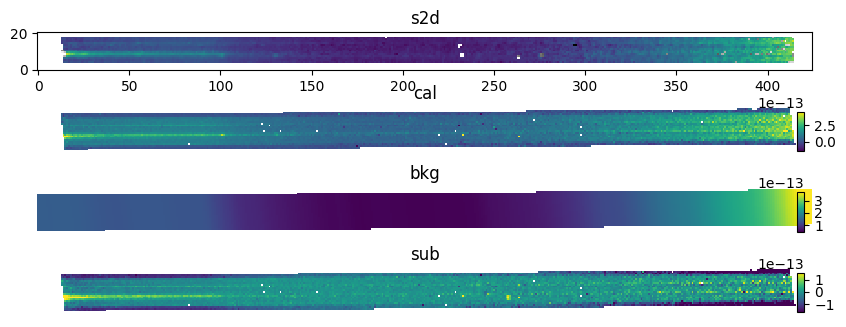

2025-03-18 19:23:11,381 - stpipe - INFO - [12525]  [BetterBackground] : Initializing Better Background NIRSpec


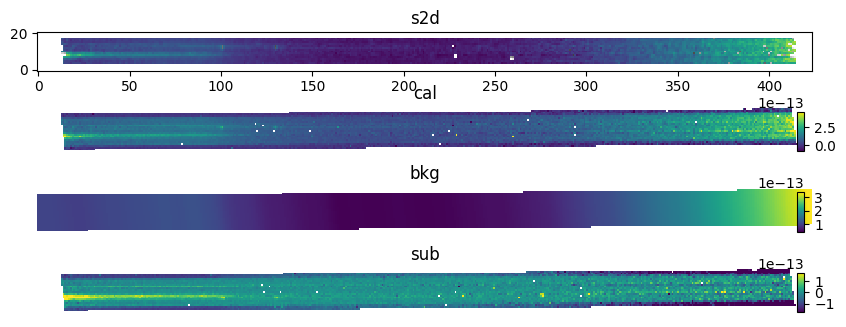

2025-03-18 19:23:11,761 - stpipe - INFO - [12525]  [BetterBackground] : Initializing Better Background NIRSpec


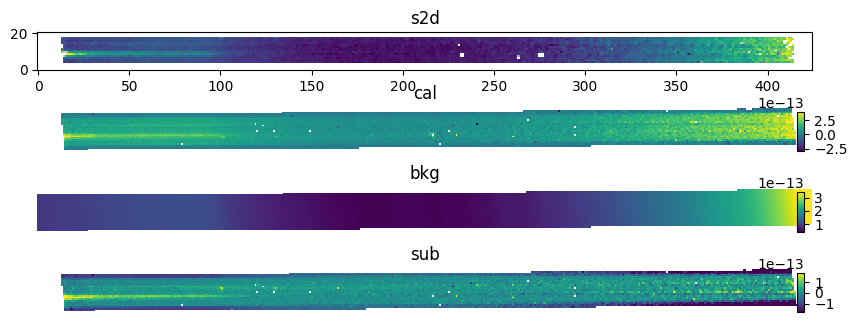

2025-03-18 19:23:12,139 - stpipe - INFO - [12525]  [BetterBackground] : Initializing Better Background NIRSpec


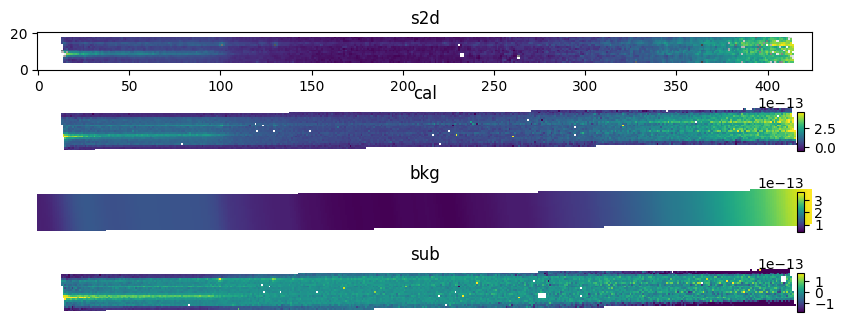

2025-03-18 19:23:12,511 - stpipe - INFO - [12525]  [BetterBackground] : Initializing Better Background NIRSpec


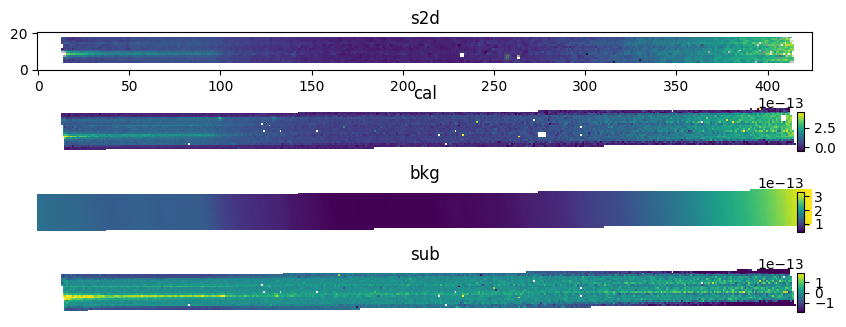

2025-03-18 19:23:12,885 - stpipe - INFO - [12525]  [BetterBackground] : Initializing Better Background NIRSpec


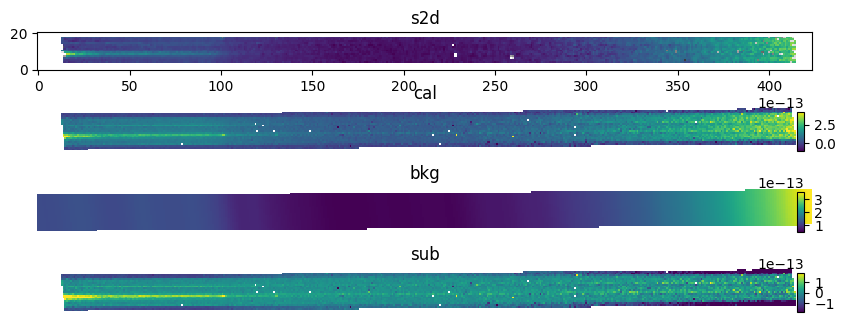

2025-03-18 19:23:13,481 - stpipe - INFO - [12525]  [BetterBackground] : Initializing Better Background NIRSpec


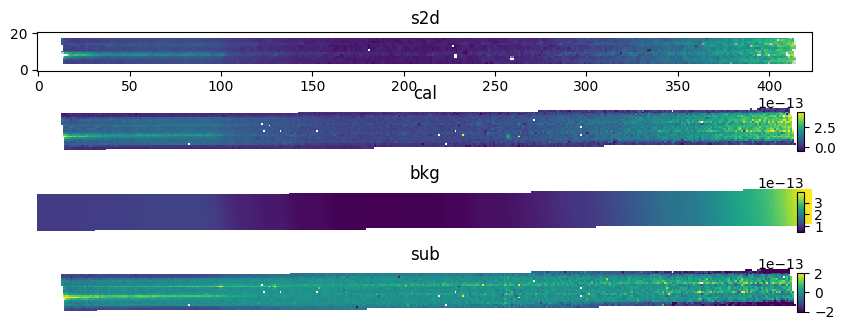

2025-03-18 19:23:13,810 - stpipe - INFO - [12525]  [BetterBackground] : Initializing Better Background NIRSpec


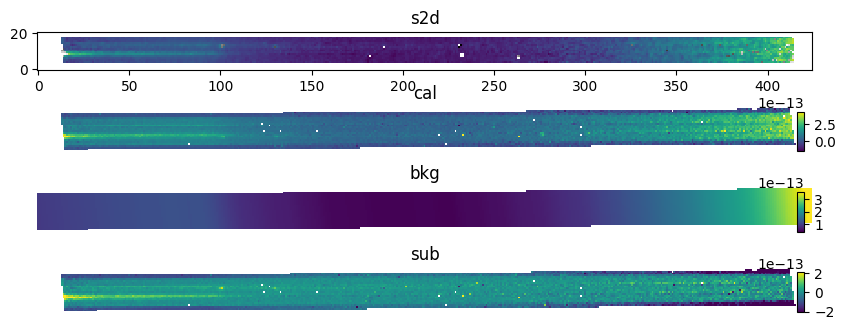

2025-03-18 19:23:14,147 - stpipe - INFO - [12525]  [BetterBackground] : Initializing Better Background NIRSpec


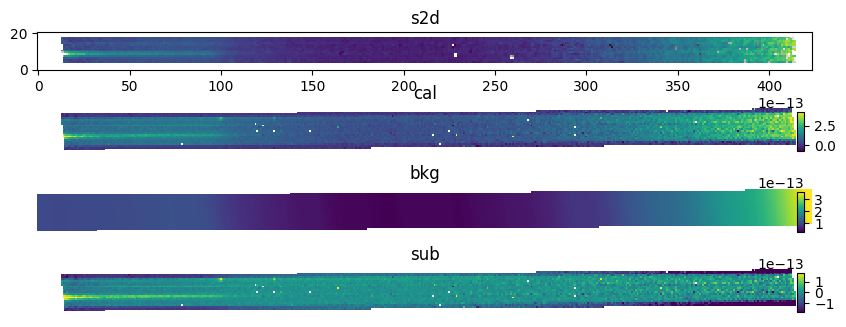

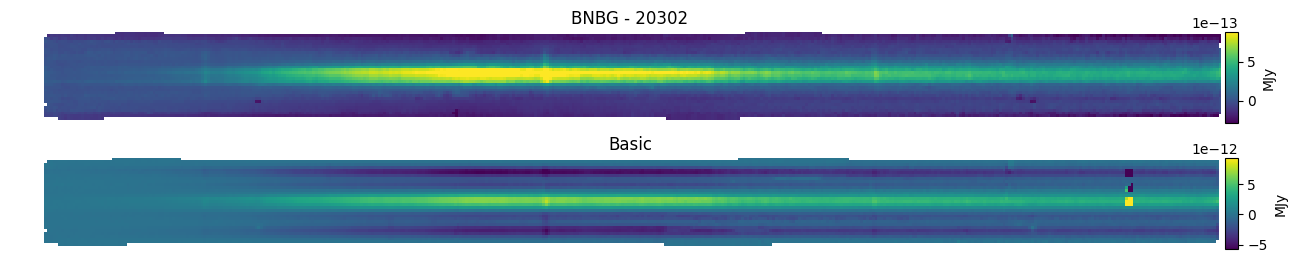

2025-03-18 19:23:14,628 - stpipe - INFO - [12525]  [BetterBackground] : Initializing Better Background NIRSpec


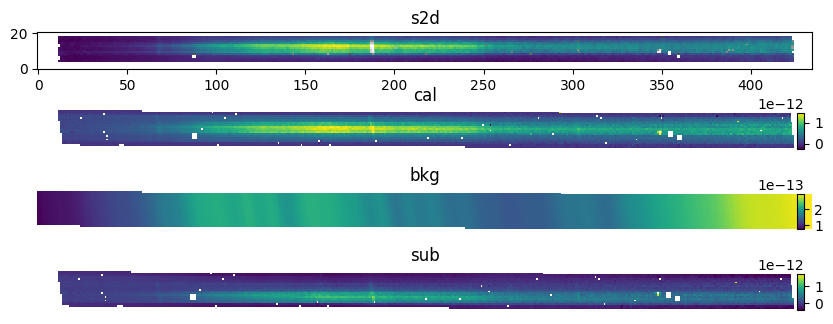

2025-03-18 19:23:14,961 - stpipe - INFO - [12525]  [BetterBackground] : Initializing Better Background NIRSpec


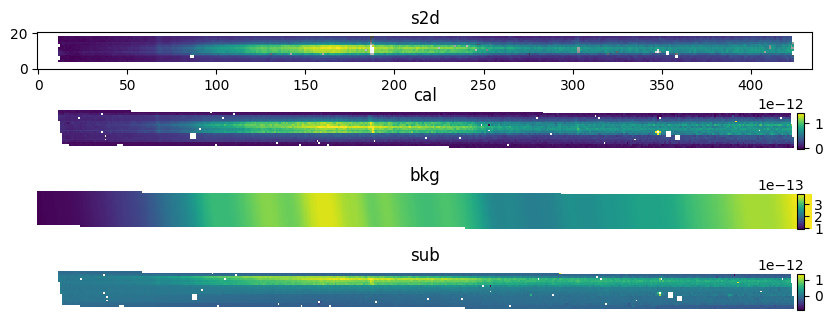

2025-03-18 19:23:15,284 - stpipe - INFO - [12525]  [BetterBackground] : Initializing Better Background NIRSpec


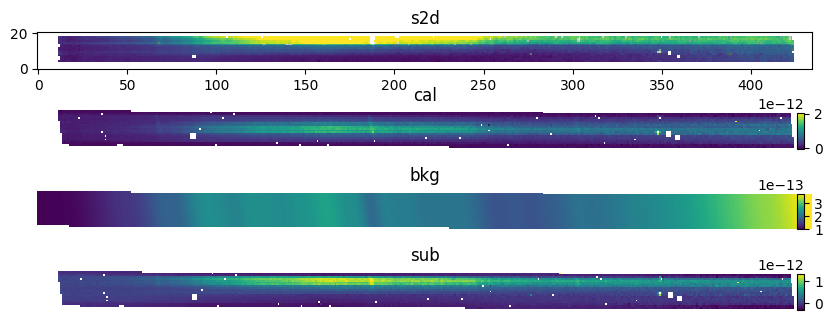

2025-03-18 19:23:15,602 - stpipe - INFO - [12525]  [BetterBackground] : Initializing Better Background NIRSpec


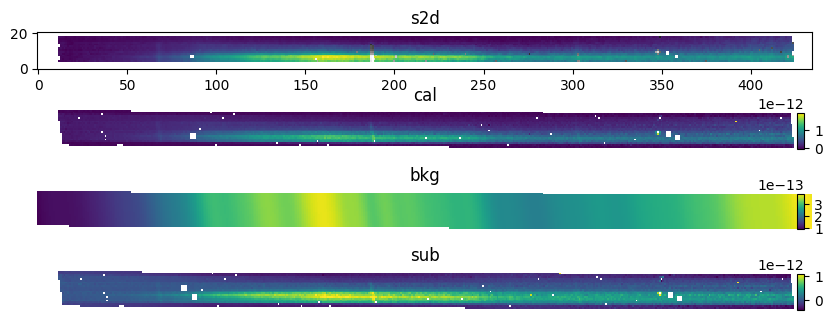

2025-03-18 19:23:15,940 - stpipe - INFO - [12525]  [BetterBackground] : Initializing Better Background NIRSpec


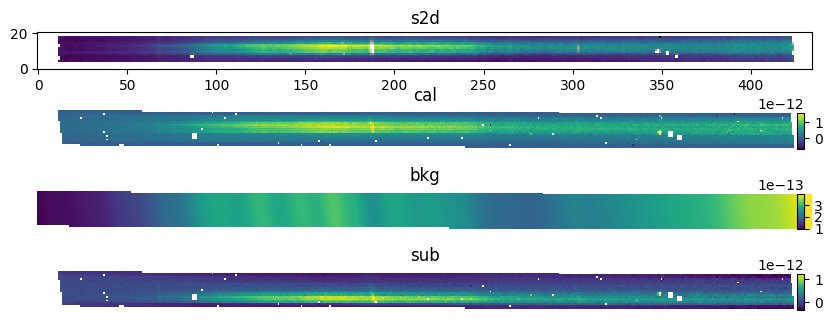

2025-03-18 19:23:16,290 - stpipe - INFO - [12525]  [BetterBackground] : Initializing Better Background NIRSpec


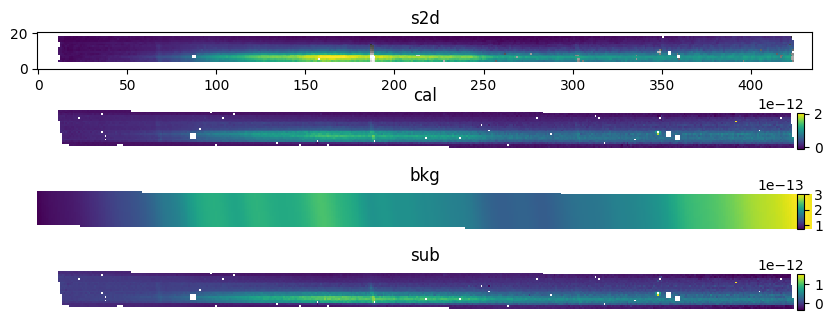

2025-03-18 19:23:16,627 - stpipe - INFO - [12525]  [BetterBackground] : Initializing Better Background NIRSpec


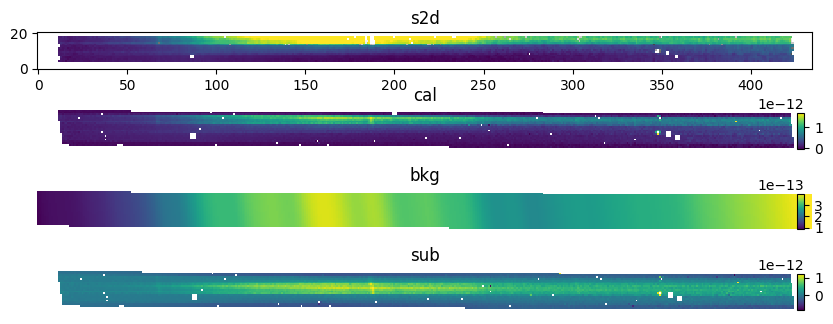

2025-03-18 19:23:16,963 - stpipe - INFO - [12525]  [BetterBackground] : Initializing Better Background NIRSpec


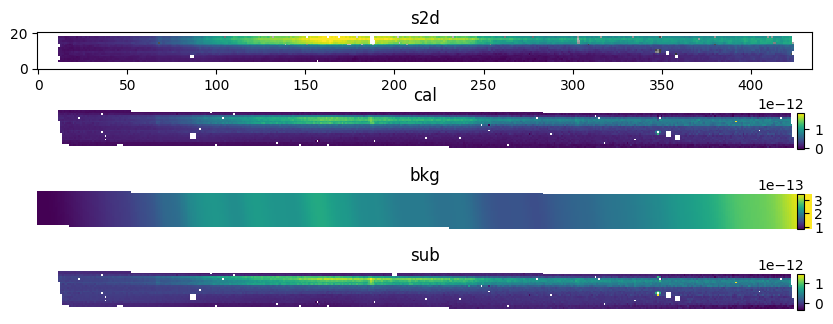

2025-03-18 19:23:17,577 - stpipe - INFO - [12525]  [BetterBackground] : Initializing Better Background NIRSpec


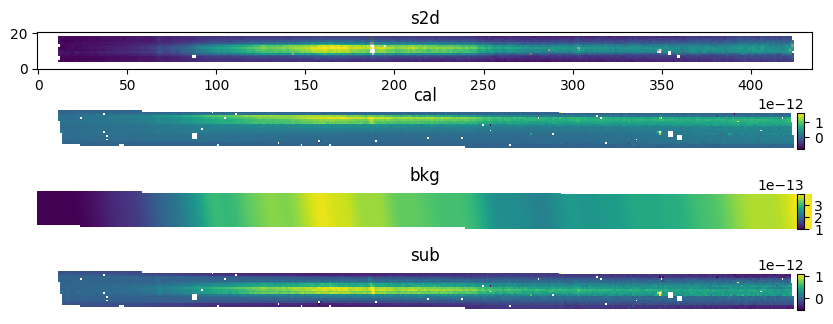

2025-03-18 19:23:17,921 - stpipe - INFO - [12525]  [BetterBackground] : Initializing Better Background NIRSpec


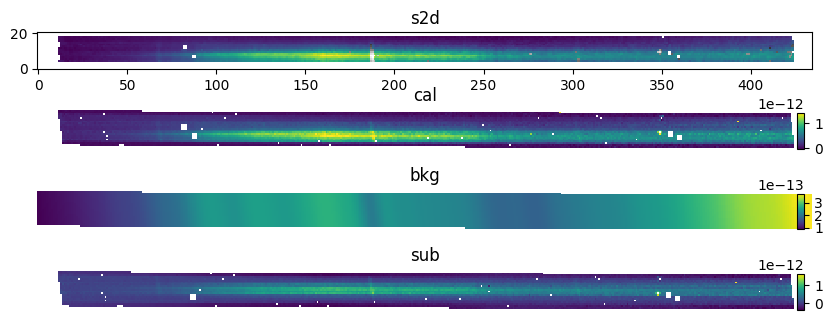

2025-03-18 19:23:18,261 - stpipe - INFO - [12525]  [BetterBackground] : Initializing Better Background NIRSpec


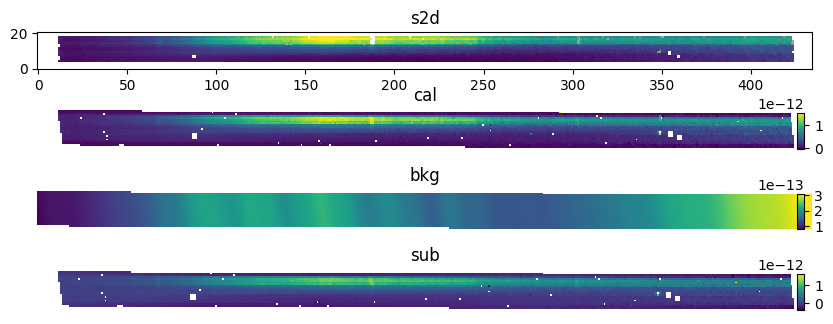

2025-03-18 19:23:18,599 - stpipe - INFO - [12525]  [BetterBackground] : Initializing Better Background NIRSpec


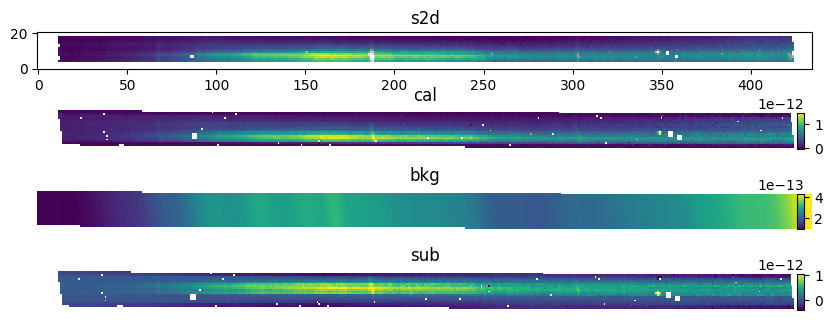

In [89]:
for idx in IDS:
	fig, ax = plt.subplots(2,1,figsize=(16,3))

	img_bnbg = bnbg_s2d[idx][1].data
	z1,z2 = ZScaleInterval().get_limits(img_bnbg)
	pcm = ax[0].imshow(img_bnbg, origin="lower", vmin=z1, vmax=z2, interpolation="none")
	cax = ax[0].inset_axes([0.98, 0, 0.01, 1])
	cbar = fig.colorbar(pcm, cax=cax, )
	cbar.set_label(bnbg_s2d[idx][1].header["BUNIT"])


	img_basic = basic_s2d[idx][1].data
	z1,z2 = ZScaleInterval().get_limits(img_basic)
	pcm = ax[1].imshow(img_basic, origin="lower", vmin=z1, vmax=z2, interpolation="none")
	cax = ax[1].inset_axes([0.98, 0, 0.01, 1])
	cbar = fig.colorbar(pcm, cax=cax)
	cbar.set_label(basic_s2d[idx][1].header["BUNIT"])

	ax[0].set_title(f"BNBG - {idx}")
	ax[1].set_title("Basic")
	ax[0].axis('off')
	ax[1].axis('off')
	plt.show()

	for s2d, cal, bkg, sub in zip(stage2_s2d[idx], stage2_cal[idx], stage2_bkg[idx], stage2_sub[idx]):
		step = BetterBackgroundStep(None, None, None)

		src = s2d.header["SRCYPOS"]
		s2d, cal, bkg, sub = s2d.data, cal.data, bkg.data, sub.data

		mask = step._cleanupImage(s2d,np.zeros_like(s2d),source=src)

		fig,ax = plt.subplots(4,1,figsize=(10,4))

		i = 1
		for img in [cal, bkg, sub]:
			z1,z2 = ZScaleInterval().get_limits(img)
			pcm = ax[i].imshow(img, origin="lower", vmin=z1, vmax=z2, interpolation="none")
			cax = ax[i].inset_axes([0.98, 0.1, 0.01, 0.8])
			cbar = fig.colorbar(pcm, cax=cax, )
			ax[i].axis('off')
			i+=1

		z1,z2 = ZScaleInterval().get_limits(s2d)
		ax[0].imshow(s2d, origin="lower", vmin=z1, vmax=z2, interpolation="none", cmap="gray")
		img = s2d.copy()
		img[mask] = np.nan
		ax[0].imshow(img, origin="lower", vmin=z1, vmax=z2, interpolation="none")

		ax[0].set_title(f"s2d")
		ax[1].set_title("cal")
		ax[2].set_title("bkg")
		ax[3].set_title("sub")

		plt.show()